## Searching for bouts for a day of alsa recording

In [1]:
%matplotlib inline

import os
import glob
import socket
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

### Fuck matplotlib, I'm using poltly now
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2023-01-04 08:54:41,141 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb

### Get the file locations for a session (day) of recordings

In [3]:
##### reload(et)
sess_par = {'bird': 's_b1321_22',
           'sess': '2023-01-03',           
            'acq_software': 'alsa',
           'derived_folder': 'bouts_ceciestunepipe',
           'auto_file': 'bout_auto_file',
           'curated_file': 'bout_curated_file',
           'super_session': 'all-sess-01'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software=sess_par['acq_software'])

raw_folder = exp_struct['folders'][sess_par['acq_software']]
bouts_folder = os.path.join(exp_struct['folders']['derived'], sess_par['derived_folder'])

In [4]:
socket.gethostname().split('.')[0]

'pakhi'

In [5]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1321_22',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/2023-01-03',
 'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/2023-01-03/alsa',
 'kwik': '/scratch/earneodo/s_b1321_22/alsa/kwik/2023-01-03',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1321_22/2023-01-03/alsa',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1321_22/2023-01-03/alsa',
 'tmp': '/scratch/earneodo/tmp',
 'msort': '/scratch/earneodo/s_b1321_22/alsa/msort/2023-01-03',
 'ksort': '/scratch/earneodo/s_b1321_22/alsa/ksort/2023-01-03/',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1321_22/2023-01-03/alsa/'}

### read a session's bouts pandas
- get the location of the file
- load the pandas pickle
- load the search/spectrogram parameters

In [6]:
pd.__version__

'1.4.2'

In [7]:
reload(sb)
hparams, bpd = sb.read_session_bouts(sess_par['bird'], sess_par['sess'], recording_software='alsa', curated=False)

In [8]:
bpd.head(5)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,waveform,valid_waveform,valid,spectrogram,confusing
0,779395,784515,37410960,37656720,"[19.92395402899511, 24.052773003429216, 15.733...",0.552476,24.052773,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,5120,"[[779395, 779425], [779560, 779590], [779690, ...",5,"[1, 13, 21, 35, 49, 60, 67, 116, 258, 270, 282...",15,341.333333,"[-2, -2, -3, -2, -3, -2, -1, -2, -3, -3, -2, -...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
1,1182800,1186920,56774400,56972160,"[1.9380094224690678, 7.398843221171856, 1.3977...",0.552476,81.261590,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,4120,"[[1182800, 1182830], [1183180, 1183215], [1185...",5,"[1, 76, 368, 379, 446, 512, 674, 818]",8,515.000000,"[11, 10, 8, 8, 7, 9, 9, 9, 8, 5, 5, 7, 7, 6, 5...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
2,1181145,1184600,56694960,56860800,"[26.211946819514793, 8.203529005903555, 6.3212...",0.471161,36.515484,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,3455,"[[1181145, 1181175], [1183295, 1183330], [1184...",3,"[5, 321, 361, 372, 390, 398, 408, 419, 430, 61...",11,314.090909,"[0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, -1, 0, -1,...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
3,1448305,1453435,69518640,69764880,"[6.085985998089352, 5.787988900656551, 3.12035...",0.471161,48.536787,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,5130,"[[1448305, 1448335], [1450695, 1450730], [1453...",4,"[10, 20, 39, 101, 174, 281, 459, 479, 632, 659...",14,366.428571,"[20, 19, 18, 20, 19, 18, 19, 19, 19, 20, 18, 1...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
4,1230575,1233645,59067600,59214960,"[21.191183350797964, 14.926242673052027, 3.886...",0.371097,21.191183,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,3070,"[[1230575, 1230615], [1233600, 1233645]]",2,"[6, 16, 605]",3,1023.333333,"[8, 10, 10, 11, 9, 9, 10, 10, 10, 9, 9, 10, 10...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True


In [9]:
bpd.index.size

26

###### if it wasnt saved (which is a bad mistake), read the sampling rate from the first file in the session

## inspect the bouts and curate them

#### visualize one bout

In [10]:
import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import widgets

In [11]:
def viz_one_bout(df: pd.Series, sub_sample=1):
    # get the power and the spectrogram
    sxx = df['spectrogram'][:, ::sub_sample]
    x = df['waveform'][::sub_sample]
    
    # the trace
    tr_waveform = go.Scatter(y=x)
    figwidg_waveform = go.FigureWidget(data=[tr_waveform],
                                      layout= {'height': 300,'width':1000})

    # the spectrogram
    fig_spectrogram = px.imshow(sxx, 
                                     labels={}, 
                                     color_continuous_scale='Inferno',
                                    aspect='auto')

    fig_spectrogram.update_layout(width=1000, height=300, coloraxis_showscale=False)
    fig_spectrogram.update_xaxes(showticklabels=False)
    fig_spectrogram.update_yaxes(showticklabels=False)
    
    
    figwidg_spectrogram = go.FigureWidget(fig_spectrogram)
    
    display(widgets.VBox([figwidg_waveform,
              figwidg_spectrogram]))
    

#viz_one_bout(bpd.iloc[1])

## use it in a widget


In [12]:
bpd.sort_values('len_ms', ascending=False, inplace=True)
bpd.reset_index(drop=True, inplace=True)

In [13]:
### Create a counter object (count goes 1:1 to DataFrame index)
from traitlets import CInt, link

class Counter(widgets.DOMWidget):
    value = CInt(0)
    value.tag(sync=True)

In [14]:
class VizBout():
    def __init__(self, hparams, bouts_pd):
        self.bout = None
        self.bouts_pd = bouts_pd
        self.bout_series = None
        self.is_bout = None
        self.is_call = None
        self.is_confusing = None
                
        self.bout_counter = None
        self.bout_id = None
        
        self.buttons = {}
        self.m_pick = None
        
        self.audio = None
        
        self.fig_waveform = None
        self.fig_spectrogram = None
        
        self.figwidg_waveform = None
        self.figwidg_spectrogram = None
        
        self.fig_width = 2
        self.sub_sample = 10
        
        self.x = None
        self.sxx = None
        self.tr_waveform = None
        
        self.s_f = hparams['sample_rate']
        
        self.init_fig()
        self.init_widget()
        self.show()
        
    def init_fig(self):
        # the trace
        self.tr_waveform = go.Scatter(y=np.zeros(500))
        self.figwidg_waveform = go.FigureWidget(data=[self.tr_waveform],
                                               layout={'width': 1000, 'height':300})
        
        # the spectrogram
        self.fig_spectrogram = px.imshow(np.random.rand(500, 500), 
                                         labels={}, 
                                         color_continuous_scale='Inferno',
                                        aspect='auto')
        
        self.fig_spectrogram.update_layout(width=1000, height=300, coloraxis_showscale=False)
        self.fig_spectrogram.update_xaxes(showticklabels=False)
        self.fig_spectrogram.update_yaxes(showticklabels=False)
        self.figwidg_spectrogram = go.FigureWidget(self.fig_spectrogram)
        
        
    def init_widget(self):
        # declare elements
        # lay them out
        #
        
        # is this the best place for this?
        self.bouts_pd['is_call'] = False
        
        self.bout_counter = Counter()
        self.is_bout = widgets.Checkbox(description='is bout')
        self.is_call = widgets.Checkbox(description='calls')
        self.is_confusing = widgets.Checkbox(description='confusing')
        
        self.buttons['Next'] = widgets.Button(description="Next", button_style='info',
                                              icon='plus')   
        self.buttons['Prev'] = widgets.Button(description="Prev", button_style='warning',
                                              icon='minus')
        self.buttons['Check'] = widgets.Button(description="Song", button_style='success', 
                                               icon='check')
        self.buttons['Uncheck'] = widgets.Button(description="Noise", button_style='danger',
                                                 icon='wrong')
        self.buttons['Call'] = widgets.Button(description="Calls")
        
        [b.on_click(self.button_click) for b in self.buttons.values()]
        
        
        top_box = widgets.HBox([self.buttons['Prev'], self.buttons['Next']])
        bottom_box = widgets.HBox([self.buttons['Uncheck'], self.buttons['Check'], self.buttons['Call']])
        button_box = widgets.VBox([top_box, bottom_box])

        self.m_pick = widgets.IntSlider(value=0, min=0, max=self.bouts_pd.index.size-1, step=1, 
                                        description="Bout candidate index")
        
        
        #self.audio = Audio(data=np.zeros(100), rate=self.s_f)
        
        control_box = widgets.HBox([button_box,
                                  widgets.VBox([self.is_bout, self.is_confusing, self.is_call]),
                                  widgets.VBox([self.m_pick])]
                                  )
        
        link((self.m_pick, 'value'), (self.bout_counter, 'value'))

        self.update_bout()
        
        self.is_bout.observe(self.bout_checked, names='value')
        self.is_call.observe(self.call_checked, names='value')
        self.is_confusing.observe(self.confusing_checked, names='value')
        
        self.m_pick.observe(self.slider_change, names='value')
        
        all_containers = widgets.VBox([control_box, 
                                       self.figwidg_waveform, self.figwidg_spectrogram])
        display(all_containers)
#         display(button_box)
#         display(self.m_pick)
#         display(self.is_bout)
#         display(self.fig)
        
    def button_click(self, button):        
        self.bout_id = self.bout_counter.value
        curr_bout = self.bout_counter
        
        if button.description == 'Next':
            curr_bout.value += 1
        elif button.description == 'Prev':
            #print('prev clicked')
            curr_bout.value -= 1
        
        elif button.description == 'Song':
            #print('check clicked')
            self.bouts_pd.loc[self.bout_id, 'bout_check'] = True
            self.bouts_pd.loc[self.bout_id, 'confusing'] = False
            self.bouts_pd.loc[self.bout_id, 'is_call'] = False
            curr_bout.value += 1
        
        elif button.description == 'Noise':
            self.bouts_pd.loc[self.bout_id, 'bout_check'] = False
            self.bouts_pd.loc[self.bout_id, 'confusing'] = False
            self.bouts_pd.loc[self.bout_id, 'is_call'] = False
            curr_bout.value += 1
        
        elif button.description == 'Calls':
            self.bouts_pd.loc[self.bout_id, 'bout_check'] = True
            self.bouts_pd.loc[self.bout_id, 'confusing'] = False
            self.bouts_pd.loc[self.bout_id, 'is_call'] = True
            curr_bout.value += 1
        
        # handle the edges of the counter
        if curr_bout.value > self.m_pick.max:
            curr_bout.value = 0
            
        if curr_bout.value < self.m_pick.min:
            curr_bout.value = self.m_pick.max
    
    def slider_change(self, change):
        #logger.info('slider changed')
        #self.bout_counter = change.new
        #clear_output(True)
        self.update_bout()
        self.show()
            
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.loc[self.bout_id, 'bout_check'] = bc['new']
        #self.bouts_pd.loc[self.bout_id, 'is_call'] = False # if it is 
    
    def call_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.loc[self.bout_id, 'is_call'] = bc['new']
    
    def confusing_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.bouts_pd.loc[self.bout_id, 'confusing'] = bc['new']
    
    
    
    def update_bout(self):
        self.bout_id = self.bout_counter.value
        self.bout_series = self.bouts_pd.iloc[self.bout_id]
        
        self.is_bout.value = bool(self.bout_series['bout_check'])
        self.is_call.value = bool(self.bout_series['is_call'])
        self.is_confusing.value = bool(self.bout_series['confusing'])
                
        self.x = self.bout_series['waveform'][::self.sub_sample]
        self.sxx = self.bout_series['spectrogram'][::self.sub_sample]
        
        #self.audio = Audio(data=self.x.flatten(), rate=self.s_f)
        
    def show(self):
        #self.fig.clf()
        #self.init_fig()
        # update
#         self.update_bout()
        #plot
        #logger.info('showing')
        
        # Show the figures
        with self.figwidg_waveform.batch_update():
            self.figwidg_waveform.data[0].y = self.x
            self.figwidg_waveform.data[0].x = np.arange(self.x.size) * self.sub_sample / self.s_f 
            
        with self.figwidg_spectrogram.batch_update():
            self.figwidg_spectrogram.data[0].z = np.sqrt(self.sxx[::-1])
            
        

viz_bout = VizBout(hparams, bpd)

In [15]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
np.where((viz_bout.bouts_pd['bout_check']==True) & (viz_bout.bouts_pd['confusing']==False) & (bpd['len_ms']>10000))[0].size

### save it

In [16]:
### get the curated file path
##save to the curated file path
bouts_curated_file_path = os.path.join(bouts_folder, hparams['bout_curated_file'])

os.makedirs(bouts_folder, exist_ok=True, mode=0o777)

viz_bout.bouts_pd.to_pickle(bouts_curated_file_path)
logger.info('saved curated bout pandas to pickle {}'.format(bouts_curated_file_path))

2023-01-04 08:56:13,213 root         INFO     saved curated bout pandas to pickle /mnt/sphere/speech_bci/derived_data/s_b1321_22/2023-01-03/alsa/bouts_ceciestunepipe/bout_checked.pickle


### Curated bouts longer than 10 seconds

2023-01-04 08:56:14,381 root         INFO     Number of bouts: 3
2023-01-04 08:56:14,382 root         INFO     Length of all bouts (minutes): 0.9385833333333333


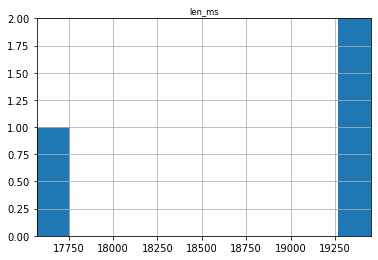

In [17]:
def sess_bout_summary(bout_pd: pd.DataFrame, ax_dict: dict=None, bouts_type='curated', min_len_ms=7000) -> pd.DataFrame:
    ## make and plot a summary of the bird's bout.
    # get lengths of the bouts
    # get estimate timestamps of bouts
    # plot histogram length of bouts
    # histogram of time of bouts
    bout_sel = (bout_pd['valid']==True) & (bout_pd['len_ms'] > min_len_ms);
    if bouts_type=='curated':
        bout_sel = bout_sel & (bout_pd['bout_check']==True) & (bout_pd['confusing']==False);
    
    # len/time? (when do they sing the longest?)
    logger.info('Number of bouts: {}'.format(bout_pd.loc[bout_sel].index.size))
    logger.info('Length of all bouts (minutes): {}'.format(bout_pd.loc[bout_sel, 'len_ms'].values.sum()/60000))
    
    if ax_dict is None:
        bout_pd.loc[bout_sel].hist(column='len_ms')
    return bout_pd

bpd = sess_bout_summary(bpd)

### update bout summary for the bird

In [18]:
reload(sb)
#all_meta_pd, all_bout_pd = sb.load_all_bouts(sess_par)
all_meta_pd, all_bout_pd = sb.update_bouts(sess_par)

2023-01-04 08:56:15,593 ceciestunepipe.pipeline.searchbout INFO     Looking for all sessions with bouts detected/curated for bird s_b1321_22
2023-01-04 08:56:15,594 ceciestunepipe.pipeline.searchbout INFO     Loading bout summary dataframe
2023-01-04 08:56:15,595 ceciestunepipe.pipeline.searchbout INFO     Meta, bout summary path is /mnt/sphere/speech_bci/processed_data/s_b1321_22/all-sess-01/alsa/bouts_ceciestunepipe/bout_meta_df.pickle, /mnt/sphere/speech_bci/processed_data/s_b1321_22/all-sess-01/alsa/bouts_ceciestunepipe/bout_summary_df.pickle
2023-01-04 08:56:17,072 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2023-01-04/alsa/bouts_ceciestunepipe
2023-01-04 08:56:17,173 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2023-01-04/alsa/bouts_ceciestunepipe
2023-01-04 08:56:17,177 ceciestunepipe.pipeline.searchbout INFO     Will revisit 

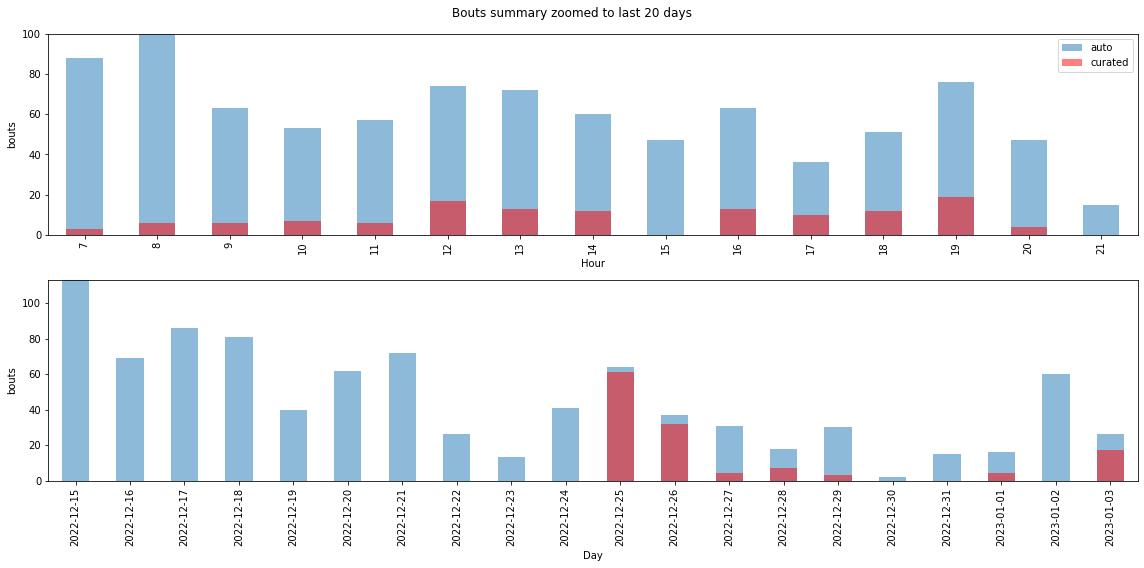

In [19]:
ax_dict = sb.plot_bout_stats(all_bout_pd, zoom_days=20)